# code from before

In [2]:
import pickle
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output
from matplotlib.patches import FancyArrow

# <font color="gray"> helper code

In [3]:
sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_821911/473825948.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


In [4]:
def plot_sttc(sd):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            sttc[i][j] = sd.spike_time_tiling(i,j)
    plt.imshow(sttc)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()

In [5]:
def find_sttc_above_threshold(sd, threshold=0.2):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            if i == j: 
                sttc[i][j]=0
            else:
                sttc[i][j] = sd.spike_time_tiling(i, j)

    # Create a mask to filter STTC values above the given threshold
    mask = sttc > threshold

    # Find the indices of neuron pairs with STTC above the threshold
    neuron_pairs = np.transpose(np.where(mask))

    return neuron_pairs



# <font color="brown">Matt Stuff

## Get raw latencies

Get initial neuron pairs

In [79]:
# Usage example:
# Assuming you have a spike data object called 'sd'
neuron_pairs_above_threshold = find_sttc_above_threshold(sd, threshold=0.6)

In [80]:
print(neuron_pairs_above_threshold)
print(len(neuron_pairs_above_threshold))

[[  4 113]
 [ 12  31]
 [ 13  21]
 [ 13  45]
 [ 16  69]
 [ 17  43]
 [ 21  13]
 [ 21  45]
 [ 24  85]
 [ 25 105]
 [ 30  95]
 [ 31  12]
 [ 33  44]
 [ 35  50]
 [ 37  81]
 [ 39  53]
 [ 40  41]
 [ 40  55]
 [ 40  87]
 [ 41  40]
 [ 43  17]
 [ 44  33]
 [ 45  13]
 [ 45  21]
 [ 50  35]
 [ 53  39]
 [ 55  40]
 [ 55  87]
 [ 58  77]
 [ 60  98]
 [ 61  98]
 [ 67  84]
 [ 69  16]
 [ 77  58]
 [ 80 111]
 [ 81  37]
 [ 84  67]
 [ 85  24]
 [ 87  40]
 [ 87  55]
 [ 95  30]
 [ 98  60]
 [ 98  61]
 [101 133]
 [105  25]
 [111  80]
 [112 118]
 [113   4]
 [118 112]
 [133 101]]
50


This function is very inefficient, consider changing it.

In [81]:
lates_raw = []
for i, neuron_pair in enumerate(neuron_pairs_above_threshold):
    print(i)
    neuron1, neuron2 = neuron_pair
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw.append( lates_n1[neuron2] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Save data, in case kernel breaks

## Save Data

In [82]:
import pickle

In [ ]:
file_path = 'StitchedData.pkl'

In [83]:
data = { "pairs":neuron_pairs_above_threshold, "latencies":lates_raw }

In [84]:
# open a file, where you ant to store the data
file = open('latencies_raw.pckl', 'wb')
pickle.dump(data, file)
file.close()

## Load Data

In [85]:
import pickle
file = open('latencies_raw.pckl', 'rb')
data = pickle.load(file)
lates_pairs = data["pairs"]
lates = data["latencies"]
file.close()

In [86]:
len(lates_pairs)

50

## Remove long latencies

In [87]:
max_ms = 10

In [88]:
lates_short = []
for latency_dist in lates:
    lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

## Latenceis Directionality

In [97]:
direction_threshold = .75

In [98]:
lates_directed = []
pairs_directed = []

In [99]:
for i in range(len(lates_short)):
    lates_i = np.array(lates_short[i])
    percent_neg = sum( lates_i<0 )/len(lates_i)
    percent_pos = sum( lates_i>0 )/len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        lates_directed.append( lates_i )
        pairs_directed.append( lates_pairs[i] )

In [100]:
len( pairs_directed )

28

## Plot Latencies in  Layout view

get neuron x and y values

In [101]:
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])


/tmp/ipykernel_821911/1018948306.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


### plot attempt 1

/tmp/ipykernel_821911/2237137338.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=20,


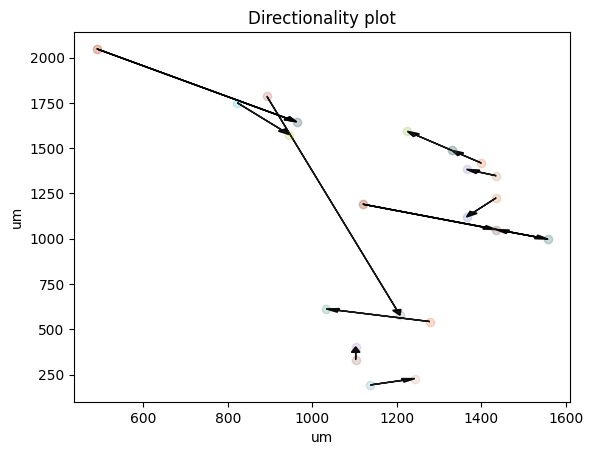

In [102]:
# Set up figure
plt.figsize= (1,1)

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    # plot dummy points, delete this soon  
    plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=.1 )
    plt.scatter( neuron_x[end_i], neuron_y[end_i], alpha=.1 )
    
    # add arrow
    arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=20,
                                       linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
    plt.gca().add_patch(arrow)

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

### print euclidean distance

In [36]:


# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    pair_distance = np.sqrt( (neuron_x[end_i] - neuron_x[start_i] )**2 + (neuron_y[end_i] - neuron_y[start_i] )**2 )
    print(pair_distance)
    

234.7871376374779
144.30869689661813
344.7100230628637
477.9775099311682
126.19429464123962
344.7100230628637
133.2760293526184
213.6147232753398
78.26237921249263
1247.9107540204948
126.19429464123962
126.19429464123962
477.9775099311682
133.2760293526184
126.19429464123962
70.0
140.0
98.99494936611666
620.695174783887
620.695174783887
110.67971810589327
224.1093483101497
98.99494936611666
148.49242404917499
1247.9107540204948
110.67971810589327
213.6147232753398
234.7871376374779
620.695174783887
620.695174783887
144.30869689661813
70.0
70.0
78.26237921249263
148.49242404917499
148.49242404917499
254.80384612481814
254.80384612481814
224.1093483101497
140.0
70.0
148.49242404917499


### example 

example case

In [ ]:
i = 0 

In [ ]:
lates_directed[i]

In [ ]:
i
pairs_directed[i]

Get starting and ending location for arrow

In [ ]:
is_pos = np.median(lates_directed[i])>0

In [ ]:
if is_pos:
    start_i =  pairs_directed[i][0]
    end_i = pairs_directed[i][1]
else:
    start_i =  pairs_directed[i][1]
    end_i = pairs_directed[i][0] 

Calculate distance

In [ ]:
pair_distance = np.sqrt( (neuron_x[end_i] - neuron_x[start_i] )**2 + (neuron_y[end_i] - neuron_y[start_i] )**2 )

plot arrow

In [ ]:
arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=2,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
plt.gca().add_patch(arrow)

In [ ]:
neuron_x[start_i]

In [ ]:
neuron_x[end_i]

### plot

In [ ]:
#fig, ax = plt.subplots(figsize=(8, 6))
plt.figsize= (8,6)
plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=0 )
#plt.xlim(500,1600)
#plt.ylim(0,2200)
arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=3,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
plt.gca().add_patch(arrow)


plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(neuron_x[start_i], neuron_y[start_i], alpha=0)
arrow = FancyArrow(neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                   length_includes_head=True, head_width=3, linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
ax.add_patch(arrow)
plt.xlim(500, 1600)
plt.ylim(0, 2200)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title
plt.show()

### <font color="brown">reference code

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)
threshold = thresh
sttc = inp_sd.spike_time_tilings()
for i in range(sttc.shape[0]):
    for j in range(sttc.shape[1]):
        if i <= j:
            continue
        if sttc[i, j] < threshold:
            continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
            continue
        ix, iy = inp_sd.neuron_data[0][i]['position']
        jx, jy = inp_sd.neuron_data[0][j]['position']
        linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
        opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
        if upd_node_info[i] == 'blue' and upd_node_info[j] == 'red':
            linewidth = 2.0  # Set a thicker linewidth
            arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                               linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
            plt.gca().add_patch(arrow)
        else:
            ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title

In [ ]:
neuron_x[start_i]

In [ ]:
neuron_y[start_i]

In [ ]:
neuron_x[end_i]

In [ ]:
neuron_y[end_i]

In [ ]:
arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=2,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

In [ ]:
sum(lates_directed[i]==0)/len(lates_directed[i])

In [ ]:
pairs_directed

### Plot all latencies

### Plot only nearby neurons

In [ ]:
lates_pair = np.array( lates_raw[0] )

In [ ]:
percent_neg = sum( lates_pair<0 )/len(lates_pair)

In [ ]:
percent_neg

In [ ]:
 np.array(test) < 0

In [ ]:
check

In [ ]:
check

In [ ]:
lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

In [ ]:
neuron_pairs_above_threshold

# <font color="gray">refrerence code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latency_histograms_for_random_pairs(sd, threshold=0.3, num_random_pairs=30):
    neuron_pairs = find_sttc_above_threshold(sd, threshold)

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_neuron_pairs = neuron_pairs[random_indices]
    
    fig, axs = plt.subplots(8, 8, figsize=(30, 30))
    axs = axs.ravel()

    # Collect latency data from all neuron pairs
    all_lates = []

    for i, neuron_pair in enumerate(random_neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        all_lates.extend(lates)  # Collect all latencies for setting common axis limits

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)

        axs[i].hist(lates, bins=10, alpha=0.7, label='Latency')
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')

        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Latency Histogram - Neuron Pair {neuron1} and {neuron2}")

    # Calculate common axis limits from all latencies
    common_x_limit = (-10, 10)  # You can adjust the range if needed
    common_y_limit = (0, len(all_lates)//10)  # Dividing by 10 just to set a reasonable range for the y-axis

    # Set common axis limits for all subplots
    for ax in axs:
        ax.set_xlim(common_x_limit)
        ax.set_ylim(common_y_limit)

    # Hide unused subplots
    for i in range(num_random_pairs, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('LatencyDistributions.png')
    plt.show()

# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(sd, threshold=0.48, num_random_pairs=64)